In [171]:
import torch
import torchvision.transforms as transforms
import os
import torch.nn.functional as F
# 학습 중 진행상황 print(진행률 막대)
import tqdm
import random
import cv2
from ipywidgets import interact
# 파일 및 디렉토리 작업
import shutil
import numpy as np
from PIL import Image
import re
# 다차원 이미지 처리
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
# 파일경로 다루기
from pathlib import Path
from torch import nn
# 텐서를 감싸기
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, random_split

# 1. 이미지 경로지정

In [172]:
# 원본 데이터셋 경로
dataset_dir = r'D:\Breast  Cancer Segmentation\Breast Cancer'

In [173]:
# 각 폴더에 대한 이미지 경로 dic생성(benign:양성 / malignant:악성 / normal:정상)
folder_list = os.listdir(dataset_dir)
folder_dic = {}
for i in folder_list:
    folder_dir = os.path.join(dataset_dir,i)
    img_list = os.listdir(folder_dir)
    img_list = [os.path.join(folder_dir,i) for i in img_list]
    folder_dic[i] = img_list

In [174]:
folder_list

['benign', 'malignant', 'normal']

In [175]:
folder_dic['benign']

['D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (1).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (1)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (10).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (10)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (100)_mask_1.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (101).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (101)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (102).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (102)_mask.png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\benign\\benign (103).png',
 'D:\\Breast  Cancer Segmentation\\Breast Cancer\\

In [176]:
# 각각 폴더 리스트 생성
benign_list = folder_dic['benign']
malignant_list = folder_dic['malignant']
normal_list = folder_dic['normal']

In [191]:
# image, mask 결합확인
def show_mask(image, mask, cmap=None, alpha=0.4):
    image = cv2.imread(image)
    mask = cv2.imread(mask)
    plt.imshow(image)
    plt.imshow(mask, cmap=cmap, alpha=alpha)
    # plt.imshow(np.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

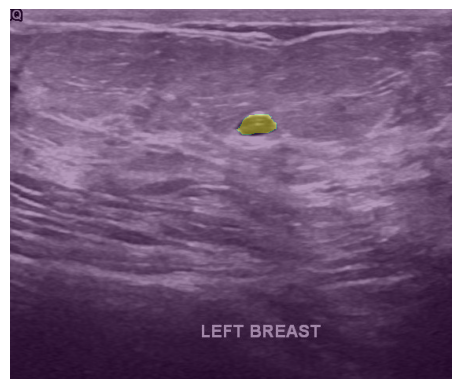

In [178]:
img = benign_list[0]
msk = benign_list[1]
show_mask(img, msk)

In [179]:
# 인터랙티브 함수 정의
index_name = input("Enter the folder name: ")
print(index_name)
index_list = folder_dic[index_name]
@interact(index=(0, len(index_list)-1))
def interact_image(index):
    img = cv2.imread(index_list[index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_title = index_list[index].split('\\')[-1]
    plt.title(img_title)
    plt.imshow(img)

Enter the folder name:  normal


normal


interactive(children=(IntSlider(value=132, description='index', max=265), Output()), _dom_classes=('widget-int…

# 2. UNet 데이터셋 생성(img / mask)

In [180]:
# unet 데이터셋 폴더생성
img_msk_list = ['image','mask']
new_dataset_path = Path('./02. Unet_Dataset')
class_list = folder_list
unet_folder_list = []
for i in img_msk_list: 
    for j in class_list:
        unet_folder_list.append(new_dataset_path / i / j)
        (new_dataset_path / i / j).mkdir(parents=True, exist_ok=True)

In [181]:
# unet 데이터셋 이미지 복사
for i in class_list:
    for j in folder_dic[i]:
        # mask이미지 복사
        if 'mask' in j:
            destination = (new_dataset_path / 'mask' / i)
            # _mask 삭제
            destination_file = destination / Path(j).name.replace('_mask','').replace(' ', '').replace('(', '').replace(')', '')
            img = cv2.imread(j, cv2.IMREAD_GRAYSCALE)
            resized_img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(str(destination_file), resized_img)
        # image복사
        elif 'mask' not in j:
            destination = (new_dataset_path / 'image' / i)
            # 파일명 정리
            destination_file = destination / Path(j).name.replace(' ', '').replace('(', '').replace(')', '')
            img = cv2.imread(j)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(img, (256,256), interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(str(destination_file), resized_img)

In [182]:
# # unet 데이터셋 이미지 복사
# for i in class_list:
#     for j in folder_dic[i]:
#         # mask이미지 복사
#         if 'mask' in j:
#             destination = (new_dataset_path / 'mask' / i)
#             # _mask 삭제
#             destination_file = destination / Path(j).name.replace('_mask','').replace(' ', '').replace('(', '').replace(')', '')
#             shutil.copy2(j, destination_file)
#         # image복사
#         elif 'mask' not in j:
#             destination = (new_dataset_path / 'image' / i)
#             # 파일명 정리
#             destination_file = destination / Path(j).name.replace(' ', '').replace('(', '').replace(')', '')
#             shutil.copy2(j, destination)

In [183]:
# 마스크이미지 경로 추출
mask_dir = r'.\02. Unet_Dataset\mask'
mask_folders = os.listdir(mask_dir)
all_mask = []
for i in mask_folders:
    path = os.path.join(mask_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_mask.append(whole_path)
len(all_mask)

798

In [184]:
# 중복되는 마스크 통합
for file in all_mask:
    file_name = file.split('\\')[-1]
    if '_' in file_name:
        path1 = file.replace('_1','').replace('_2','')
        path2 = file
        img1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
        dst = cv2.add(img1, img2)
        cv2.imwrite(path1, dst)
        os.remove(file)

In [185]:
# 마스크이미지 경로 추출
mask_dir = r'.\02. Unet_Dataset\mask'
mask_folders = os.listdir(mask_dir)
all_mask = []
for i in mask_folders:
    path = os.path.join(mask_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_mask.append(whole_path)
len(all_mask)

780

In [186]:
# 마스크이미지 경로 추출
image_dir = r'.\02. Unet_Dataset\image'
image_folders = os.listdir(image_dir)
all_image = []
for i in image_folders:
    path = os.path.join(image_dir, i)
    files = os.listdir(path)
    for j in files:
        whole_path = os.path.join(path, j)
        all_image.append(whole_path)
len(all_image)

780

In [187]:
# bengin / malignant -> 색상변경
benign_dir = os.path.join(mask_dir, 'benign')
malignant_dir = os.path.join(mask_dir, 'malignant')
benign_files = [os.path.join(benign_dir,i) for i in os.listdir(benign_dir)]
malignant_files = [os.path.join(malignant_dir,i) for i in os.listdir(malignant_dir)]
print(len(benign_files),len(malignant_files))

437 210


In [188]:
# benign 양성(종양) - 파란색 표현
for i in benign_files:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    _,img_white = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bgr[img_white == 255] = [255, 0, 0]
    cv2.imwrite(i, img_bgr)

In [189]:
# malignant 악성(암) - 붉은색 표현
for i in malignant_files:
    img = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    _,img_white = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img_bgr[img_white == 255] = [0, 0, 255]
    cv2.imwrite(i, img_bgr)

In [193]:
# unet데이터셋 확인
all_image = sorted(all_image)
all_mask = sorted(all_mask)
@interact(index=(0, len(all_image)-1))
def interact_image(index):
    show_mask(all_image[index], all_mask[index], alpha=0.5)
    title = all_image[index].split('\\')[-1]
    plt.title(title)

interactive(children=(IntSlider(value=389, description='index', max=779), Output()), _dom_classes=('widget-int…

# 3. Unet 구현

In [194]:
# UNET 클래스로 구현
class UNet(nn.Module):
    # 클래스의 갯수 상속
    def __init__(self, num_classes):
        # nn.Module(부모) 클래스의 기능을 상속
        super(UNet, self).__init__()
        self.num_classes = num_classes
        # 3채널을 받아서 64로 반환(1번째 레이어)
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(2번째 레이어)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 128채널을 받아서 256채널로 반환(3번째 레이어)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64채널을 받아서 128채널로 반환(4번째 레이어)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 512채널을 받아서 1024채널로 반환(5번째 레이어)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        # 디코딩(확장)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        # 3
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        # 4
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        # 결과물
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=2)


    # n개의 채널을 받아서 n개의 채널로 내보내는 함수
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels),
                             nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                             nn.ReLU(),
                             nn.BatchNorm2d(num_features=out_channels))
        return block

    def forward(self, X):
        # 컨볼루션 연산 -> 채널 상승
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256] : 배치 / 채널 / 이미지사이즈
        # 맥스풀링 -> 이미지 크기 감소
        contracting_12_out = self.contracting_12(contracting_11_out) #[-1, 64, 128, 128]
        # 2
        contracting_21_out = self.contracting_21(contracting_12_out) #[-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) #[-1, 128, 64, 64]
        # 3
        contracting_31_out = self.contracting_31(contracting_22_out) #[-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) #[-1, 256, 32, 32]
        # 4
        contracting_41_out = self.contracting_41(contracting_32_out) #[-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) #[-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]

    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1,512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024,32,32] -> [-1, 512,32,32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

# 4. Dice Score와 IoU 메트릭 함수 정의하기

In [195]:
# Dice coefficient: 두 개의 집합 간의 유사성을 측정하는 데 사용되는 통계적인 지표
# # 2×∣A∩B∣ / ∣A∣+∣B∣ (교집합*2) / (a크기+b크기)
# 0에서 1까지의 값을 가지며, 1에 가까울수록 두 집합이 유사
# 1e-6: 0.000001
# assert 조건, "에러 메세지"
def dice_coeff(input, target, reduce_batch_first: bool = False, epsilon: float = 1e-6):
    # 입력텐서과 결과텐서가 동일한지 체크
    assert input.size() == target.size()
    # 입력이 3차원 이면 True(dim:차원 수 반환)
    assert input.dim() == 3 or not reduce_batch_first
    # 차원: (-1,-2)_마지막 두개 텐서(2차원)
    sum_dim = (-1,-2) if input.dim() == 2 or not reduce_batch_first else (-1,-2,-3)
    # 교집합: 2차원이면 2개에 대한 곱 / 3차원이면 마지막 세 개 차원에 대한 곱
    inter = 2*(input * target).sum(dim=sum_dim)
    # 합집합
    sets_sum = input.sum(dim=sum_dim) + target.sum(dim=sum_dim)
    # torch.where() : 조건에 다른 연산함수 / 조건을 만족하면 0번째 아니면 1번째 반환
    sets_sum = torch.where(sets_sum==0, inter, sets_sum)
    # 완벽한 0의 분모나 분자가 나오면 에러가 나서 epsilon(실수) 더 해줌
    dice = (inter + epsilon) / (sets_sum + epsilon)
    return dice.mean()

# IoU(Intersection over Union):객체 검출 및 객체 분할과 같은 컴퓨터 비전 작업에서 사용되는 평가지표
# 두 개의 영역 또는 객체가 주어졌을 때, IoU는 교집합을 합집합으로 나눈 것을 나타냄. 0에서 1사이의 값을 갖음
def iou(y_true, y_pred, epsilon: float = 1e-6):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection+epsilon) / (union+epsilon)